In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import os
import zipfile

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# 2. Unzip the dataset

zip_path = '/content/gdrive/MyDrive/grippers_data.zip'
extract_path = '/content/dataset'

print(f"Extracting {zip_path} to {extract_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete!")

# 3. Define Image Transformations
# Data augmentation and normalization for training
# Just normalization for validation and testing
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation and test sets, we don't need augmentation
test_val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Load the full dataset
# The main data folder should contain the class subfolders
data_dir = os.path.join(extract_path, os.listdir(extract_path)[0]) # Navigates into the main folder inside the zip
full_dataset = torchvision.datasets.ImageFolder(root=data_dir)

# 5. Split the dataset into training, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply the correct transforms to each dataset split
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_val_transforms
test_dataset.dataset.transform = test_val_transforms

print(f"\nDataset split:")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# 6. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created successfully!")
print("Data is ready for training.")

Mounted at /content/gdrive
Extracting /content/gdrive/MyDrive/grippers_data.zip to /content/dataset...
Extraction complete!

Dataset split:
Training set size: 399
Validation set size: 85
Test set size: 87

DataLoaders created successfully!
Data is ready for training.


In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Define the custom CNN architecture
class GripperCNN(nn.Module):
    def __init__(self):
        super(GripperCNN, self).__init__()
        # --- CNN Backbone (Feature Extractor) ---
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 64x64

        # Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 32x32

        # Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 16x16

        # --- MLP Classifier ---
        # The input features to the MLP will be 64 * 16 * 16
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(512, 4) # 4 output classes

    def forward(self, x):
        # Pass through CNN backbone
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten the output for the MLP
        x = x.view(-1, 64 * 16 * 16)

        # Pass through MLP classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # Final raw scores (logits)
        return x

# Create an instance of the model and print its structure
model = GripperCNN()
print(model)

GripperCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move the model to the selected device
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
# --- Training Loop ---
num_epochs = 25 # You can increase this later for better accuracy

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    scheduler.step(val_loss)
    val_acc = 100 * correct_val / total_val

    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print("\nTraining finished!")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25] | Train Loss: 6.7950, Train Acc: 30.58% | Val Loss: 2.3903, Val Acc: 27.06%
Epoch [2/25] | Train Loss: 2.9335, Train Acc: 41.10% | Val Loss: 1.5158, Val Acc: 43.53%
Epoch [3/25] | Train Loss: 1.3480, Train Acc: 48.87% | Val Loss: 1.1795, Val Acc: 47.06%
Epoch [4/25] | Train Loss: 1.1369, Train Acc: 50.88% | Val Loss: 1.0587, Val Acc: 57.65%
Epoch [5/25] | Train Loss: 0.9928, Train Acc: 55.39% | Val Loss: 1.0379, Val Acc: 54.12%
Epoch [6/25] | Train Loss: 0.9512, Train Acc: 59.15% | Val Loss: 0.9785, Val Acc: 47.06%
Epoch [7/25] | Train Loss: 0.8761, Train Acc: 61.65% | Val Loss: 0.9939, Val Acc: 50.59%
Epoch [8/25] | Train Loss: 0.8865, Train Acc: 60.40% | Val Loss: 0.9376, Val Acc: 55.29%
Epoch [9/25] | Train Loss: 0.8173, Train Acc: 62.91% | Val Loss: 0.9511, Val Acc: 60.00%
Epoch [10/25] | Train Loss: 0.8020, Train Acc: 63.16% | Val Loss: 0.8951, Val Acc: 58.82%
Epoch [11/25] | Train Loss: 0.7059, Train Acc: 68.17% | Val Loss: 0.9835, Val Acc: 60.00%
Epoch [12/25] | Tra

--- Final Performance on Test Set ---
              precision    recall  f1-score   support

    2-finger       0.42      0.61      0.50        18
    3-finger       0.42      0.42      0.42        19
    5-finger       0.59      0.63      0.61        27
     suction       0.77      0.43      0.56        23

    accuracy                           0.53        87
   macro avg       0.55      0.52      0.52        87
weighted avg       0.56      0.53      0.53        87



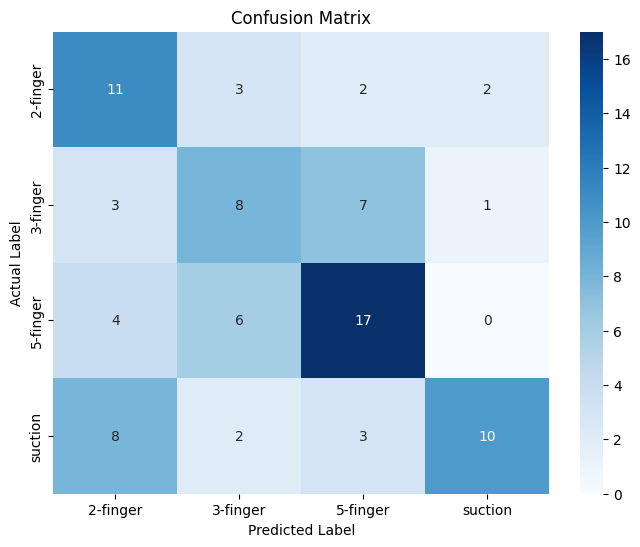

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader: # Use the test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Performance Metrics ---
print("--- Final Performance on Test Set ---")

# 1. Classification Report (Precision, Recall, F1-score)
class_names = full_dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()